## This script makes figures using the output of motor_pipeline.ipynb

### Import Packages

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
pd.set_option('display.max_rows', 500)


### Define Paths and Variables

In [2]:
grp_df = pd.read_csv('grp_df_3T.csv')
diag_df = pd.read_csv('diag_df_3T.csv')

# Choose what to analyse
networks = ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"] 
CESTnetworks = ["avgCEST_Cont", "ctCEST_Cont", "avgCEST_Default", "ctCEST_Default","avgCEST_SomMot", "ctCEST_SomMot", "avgCEST_DorsAttn", "ctCEST_DorsAttn", "avgCEST_Vis", "ctCEST_Vis","avgCEST_Limbic", "ctCEST_Limbic",  "avgCEST_SalVentAttn","ctCEST_SalVentAttn"]
CNB_scores = ["tap_tot", "er40_cr", "medf_pc"] #, 
CNB_valids = ["tap_valid", "er40_valid", "medf_valid"] #, 
diag_scores = ["dx_pscat"] # ,"axis1_desc1","axis1_stat1"
demo_scores = ["sex", "age", "race","ethnic","dateDiff"]
diag_details = ["axis1_desc1", "axis1_desc2", "axis1_desc3","axis1_desc4","axis1_desc5", "axis1_desc6"]

covariate_age = 'age' 
covariate_sex = 'sex'

### Data Trimming

In [9]:
# Standardize groups and keep only PSD or healthy
value_counts = grp_df['dx_pscat'].value_counts() 

print(value_counts)

grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('NC', 'HC')
grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('PROR', 'PSY')
grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('PRO', 'PSY')
grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('S', 'PSY')
grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('O', 'Other')
grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('Unknown', 'Other')
grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('other', 'Other')
grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('MDD', 'Other')
grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('noDSMdx', 'HC')
grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('pro', 'PSY')
grp_df['dx_pscat'] = grp_df['dx_pscat'].replace('psy', 'PSY')

#Trim NaNs and by diagnosis; rename sex variable.
#grp_df = grp_df.dropna(subset=['avgCEST_SomMot', 'SomMot', 'dx_pscat']) #
#grp_df = grp_df[grp_df['dx_pscat'] != 'Other']
grp_df['sex'] = np.where(grp_df['sex'] == 1, 'F', 'M')

#Exclude tap-tot outliers, which are >2.5 standard deviations from the mean.
grp_df = grp_df[grp_df['BBLID'] != 94703]
grp_df = grp_df[grp_df['BBLID'] != 80557]

value_counts = grp_df['dx_pscat'].value_counts() 

print(value_counts)
print(grp_df)


dx_pscat
PSY      30
HC       22
Other    10
Name: count, dtype: int64
dx_pscat
PSY      30
HC       22
Other    10
Name: count, dtype: int64
    Unnamed: 0   BBLID            Session sex    age  race  ethnic  dateDiff  \
0            0   20303          ['12276']   M  19.22   1.0     2.0      17.0   
1            1   90217          ['12064']   M  24.99   1.0     2.0      48.0   
2            2   88608        ['motive2']   M  25.36   2.0     2.0       1.0   
3            3   21874          ['12043']   M  24.14   1.0     2.0      13.0   
4            4   94288          ['11948']   M  22.68   1.0     2.0      56.0   
6            6   93757          ['12061']   M  25.37   2.0     2.0       7.0   
7            7   96902          ['11870']   M  20.76   1.0     1.0       6.0   
8            8   20792        ['motive2']   M  23.74   1.0     2.0      71.0   
9            9   20325          ['11667']   M  23.07   5.0     2.0      14.0   
10          10   88760        ['motive2']   M    NaN   NaN

### Subjects Excluded:

#### Only 4 people in other group. Given reviews on meta-analysis and small "Other" sample, exclude from present analysis.
#### Exclude outliers for taptot (i.e. >2.5 sd from sample mean of 106)
#### 
#### 



### Demographics & Summary Statistics

In [4]:
# Age
age_mean_sd_all = grp_df['age'].mean(), grp_df['age'].std(), grp_df['age'].mode(), grp_df['age'].median()
age_grps = grp_df.groupby("dx_pscat").agg(
    Age_avg = ("age", "mean"),
    Age_std = ("age", "std"))
# Sex
sex_counts = grp_df.groupby('dx_pscat')['sex'].value_counts() 
total_f = sex_counts.loc(axis=0)[:, 'F'].sum()
# Tap_tot
tap_mean_sd_all = grp_df['tap_tot'].mean(), grp_df['tap_tot'].std()
tap_grps = grp_df.groupby("dx_pscat").agg(
    tap_avg = ("tap_tot", "mean"),
    tap_std = ("tap_tot", "std"))

for network in networks:
    # CEST
    cest_mean_sd_all = grp_df['avgCEST_SomMot'].mean(), grp_df['avgCEST_SomMot'].std(), grp_df['avgCEST_SomMot'].mode(), grp_df['avgCEST_SomMot'].median()
    cest_grps = grp_df.groupby("dx_pscat").agg(
        cest_avg = ("avgCEST_SomMot", "mean"),
        cest_std = ("avgCEST_SomMot", "std"))
    # FC
    fc_mean_sd_all = grp_df['SomMot'].mean(), grp_df['SomMot'].std(), grp_df['SomMot'].mode(), grp_df['SomMot'].median()
    fc_grps = grp_df.groupby("dx_pscat").agg(
        fc_avg = ("SomMot", "mean"),
        fc_std = ("SomMot", "std"))

race_counts = grp_df.groupby('dx_pscat')['race'].value_counts()    


# Table 1 of manuscript should have:
# Average age (SD)
# Male/female
# Tap_tot scores
# Racial demographics
# Medications?
# Comorbidities

columns = ['Whole sample', 'PSY', 'HC']


demographics_table = pd.DataFrame({
    columns[0]: [f"{age_mean_sd_all[0]:.2f} ({age_mean_sd_all[1]:.2f})",
                 f"{total_f} ({total_f/sex_counts.sum():.2f})",
                 f"{tap_mean_sd_all[0]:.2f} ({tap_mean_sd_all[1]:.2f})",
                 f"{cest_mean_sd_all[0]:.2f} ({cest_mean_sd_all[1]:.2f})",
                 f"{fc_mean_sd_all[0]:.2f} ({fc_mean_sd_all[1]:.2f})"],
    
    columns[1]: [f"{age_grps.loc['PSY', 'Age_avg']:.2f} ({age_grps.loc['PSY', 'Age_std']:.2f})",
                 f"{sex_counts.loc[('PSY', 'F')]} ({sex_counts.loc[('PSY', 'F')]/sex_counts.sum():.2f})",
                 f"{tap_grps.loc['PSY', 'tap_avg']:.2f} ({tap_grps.loc['PSY', 'tap_std']:.2f})",
                 f"{cest_grps.loc['PSY', 'cest_avg']:.2f} ({cest_grps.loc['PSY', 'cest_std']:.2f})",
                 f"{fc_grps.loc['PSY', 'fc_avg']:.2f} ({fc_grps.loc['PSY', 'fc_std']:.2f})"],
    
    columns[2]: [f"{age_grps.loc['HC', 'Age_avg']:.2f} ({age_grps.loc['HC', 'Age_std']:.2f})",
                 f"{sex_counts.loc[('HC', 'F')]} ({sex_counts.loc[('HC', 'F')]/sex_counts.sum():.2f})",
                 f"{tap_grps.loc['HC', 'tap_avg']:.2f} ({tap_grps.loc['HC', 'tap_std']:.2f})",
                 f"{cest_grps.loc['HC', 'cest_avg']:.2f} ({cest_grps.loc['HC', 'cest_std']:.2f})",
                 f"{fc_grps.loc['HC', 'fc_avg']:.2f} ({fc_grps.loc['HC', 'fc_std']:.2f})"],
                 }, index=['Age (SD)', 'Sex (%)', 'Tapping Score avg (SD)', 'Avg SomMot GluCEST (SD)', 'Avg within-SomMot FC'])
                 
# Display the styled DataFrame
print(demographics_table)    

                          Whole sample            PSY             HC
Age (SD)                  22.90 (2.34)   22.97 (2.17)   22.34 (3.11)
Sex (%)                      13 (0.21)       6 (0.10)       7 (0.11)
Tapping Score avg (SD)   106.36 (9.34)  107.64 (9.51)  108.18 (8.38)
Avg SomMot GluCEST (SD)    7.58 (0.93)    7.46 (0.95)    7.61 (0.81)
Avg within-SomMot FC       0.52 (0.10)    0.50 (0.07)    0.51 (0.13)


### QA & Histograms

age Mean: 22.90
age Median: 23.12


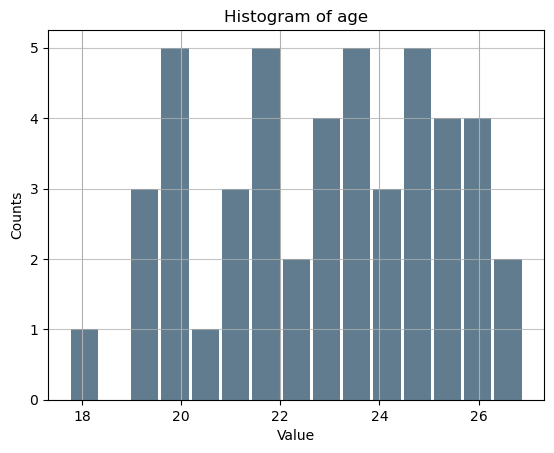

tap_tot Mean: 106.36
tap_tot Median: 104.00


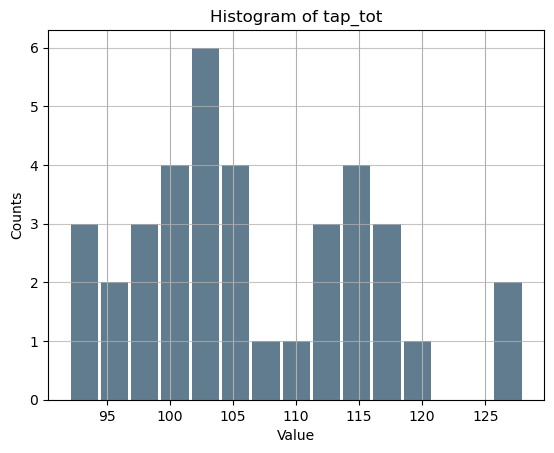

TypeError: can only concatenate list (not "str") to list

In [5]:
vars = ['age', 'tap_tot', 'SomMot', 'avgCEST_SomMot', 'ctCEST_SomMot']
vars = ['age', 'tap_tot', networks]

for var in vars:
    # QA: Compare mean and median to see if distribution is roughly normal. Visualize mode in histograms.
    mm_df = grp_df[var].mean(), grp_df[var].median()
    print(var + " Mean: " + f"{mm_df[0]:.2f}")
    print(var + " Median: " + f"{mm_df[1]:.2f}")
    
    # Make histogram
    plt.figure()
    input = pd.Series(grp_df[var])
    input.plot.hist(grid=True, bins=15, rwidth=0.9, color='#607c8e')
    plt.title('Histogram of ' + var)
    plt.xlabel('Value')
    plt.ylabel('Counts')
    plt.grid(axis='y', alpha=0.75)
    plt.show()


### Assess Demographic Variables

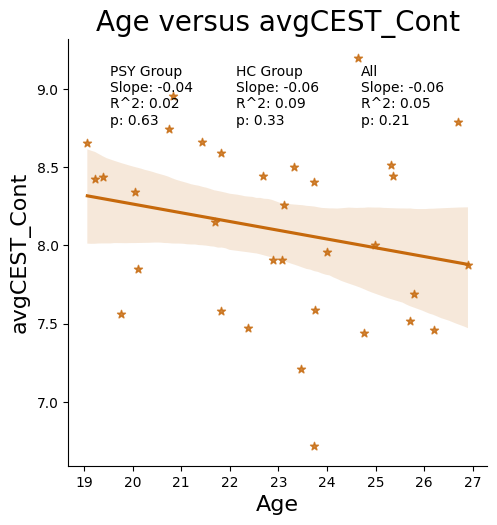

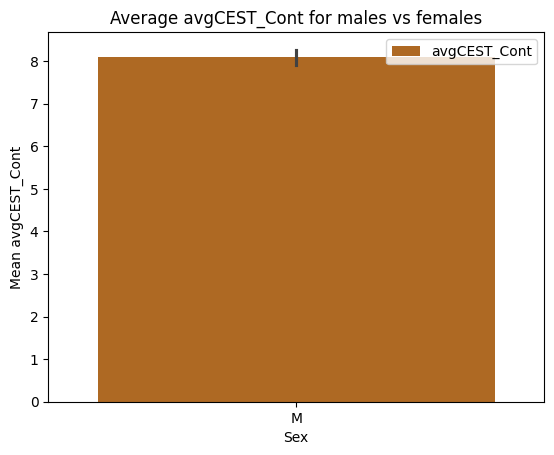

avgCEST_Contt test: t=nan, p=nan


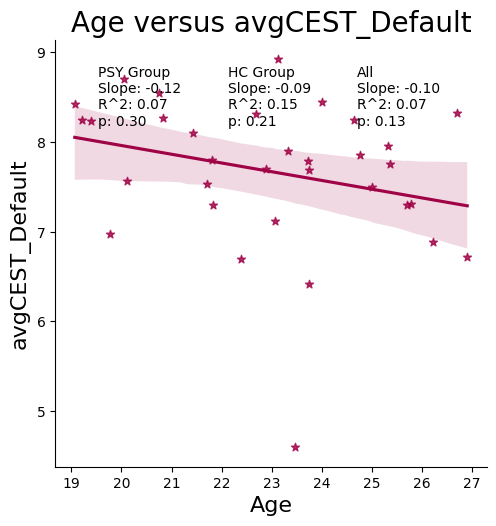

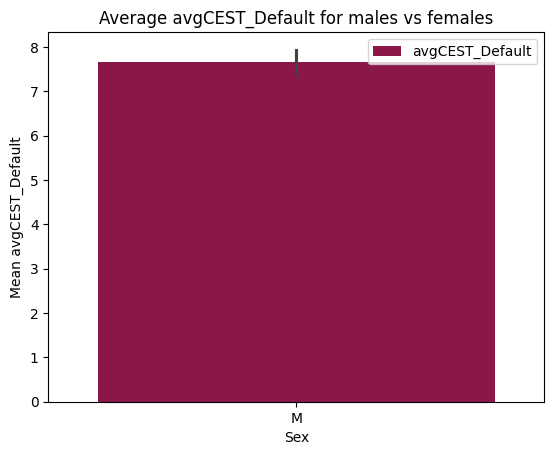

avgCEST_Defaultt test: t=nan, p=nan


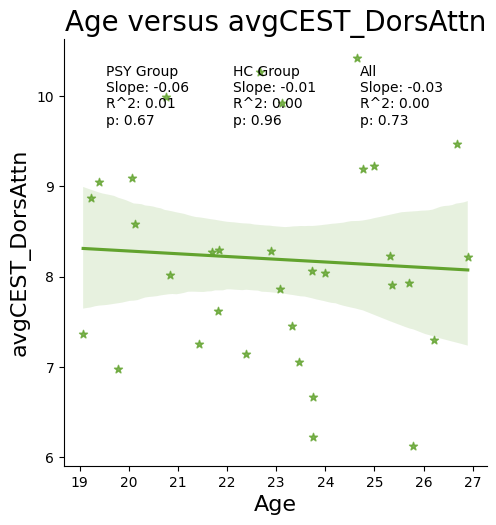

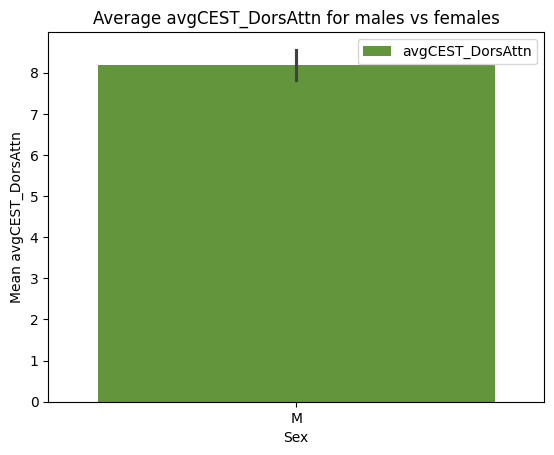

avgCEST_DorsAttnt test: t=nan, p=nan


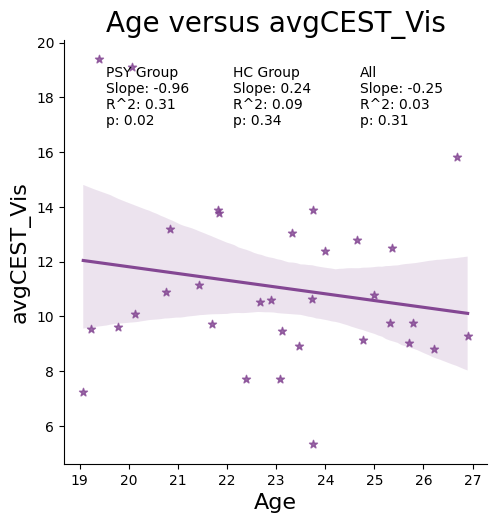

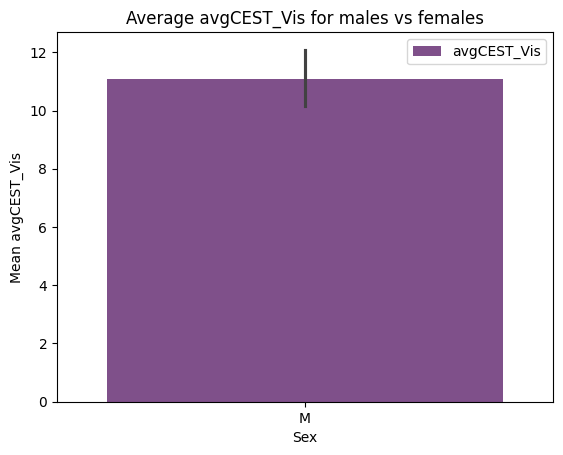

avgCEST_Vist test: t=nan, p=nan


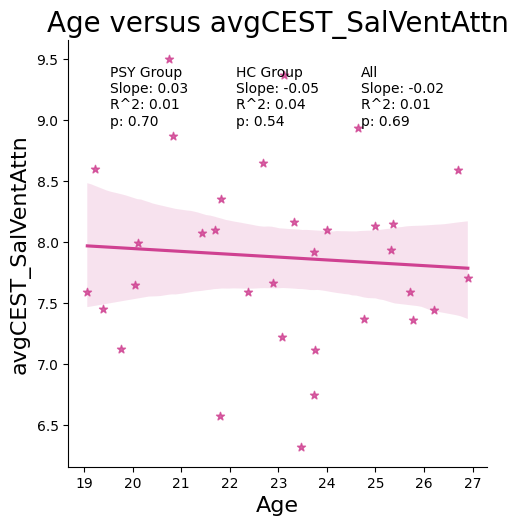

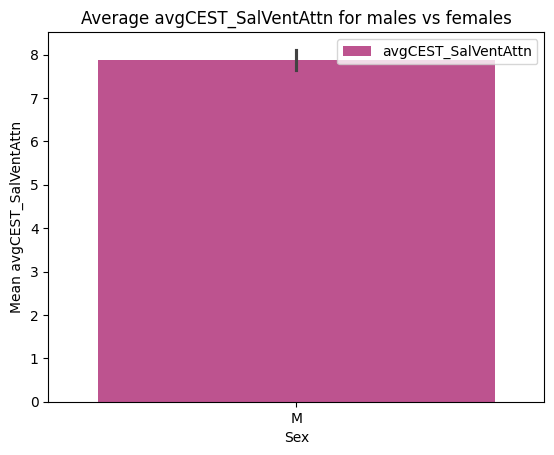

avgCEST_SalVentAttnt test: t=nan, p=nan


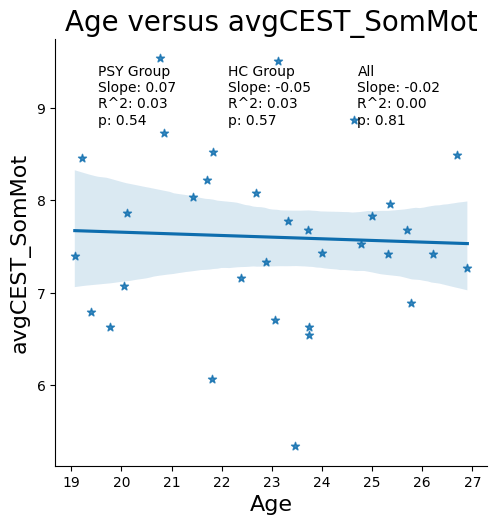

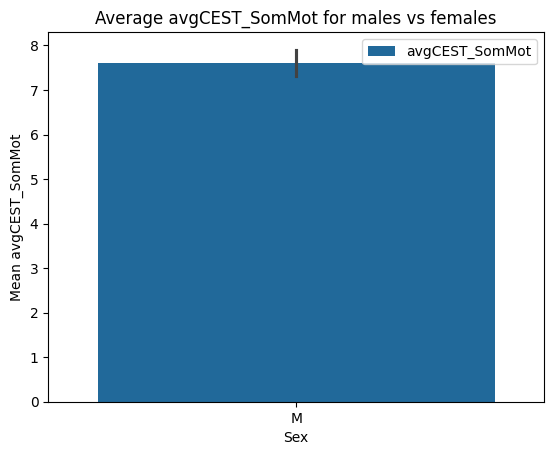

avgCEST_SomMott test: t=nan, p=nan


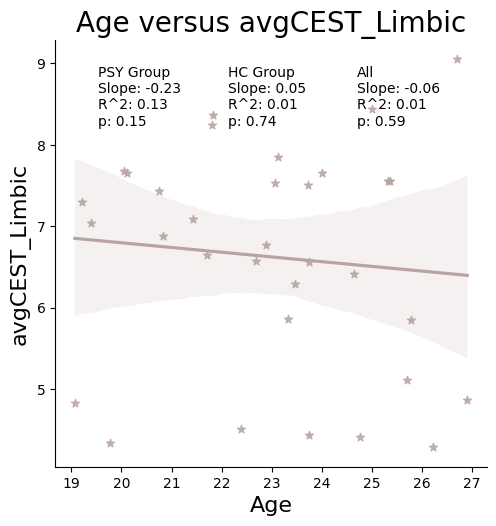

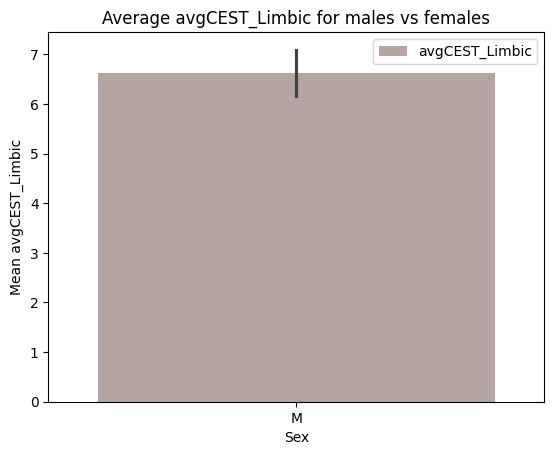

avgCEST_Limbict test: t=nan, p=nan


In [16]:
colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
    'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 

# Quality control figures
# network="SomMot"


for network in networks:
    cestcol = "avgCEST_" + network
    metrics = [cestcol] #, network
    for metric in metrics:
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[metric, 'age', 'dx_pscat'])
        #print(graph_df)
        #print(graph_df.describe())
        # Create a linear regression model for fcon
        color = colors.loc[colors['Network'] == network, 'Color'].values[0]
        sns.set_palette(color)
        plot = sns.lmplot(x='age', y=metric, data=graph_df, markers= "*") #hue='dx_pscat', 
        plt.xlabel("Age", fontsize=16)
        plt.ylabel(metric, fontsize=16)
        plt.title('Age versus ' + metric, fontsize = 20)
        # Generate and add slope, r2 and p for subset 1
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'PSY', 'age'], graph_df.loc[graph_df['dx_pscat'] == 'PSY', metric])
        #print(slope)
        plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        #     # Generate and add slope, r2 and p for subset 2
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'HC', 'age'], graph_df.loc[graph_df['dx_pscat'] == 'HC', metric])
        plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for all data
        slope, intercept, r_value, p_value, std_err = linregress(graph_df['age'], graph_df[metric])
        plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        plt.show() 
        
        # Bar plots assessing sex differences
        sns.barplot(x='sex', y=metric, data=graph_df, estimator='mean', label=metric) #yerr=avg_df[cestcol + '_std'],
        plt.xlabel('Sex')
        plt.ylabel('Mean ' + metric)
        plt.title('Average ' + metric + ' for males vs females')
        plt.legend()
        plt.show()
        t_statistic, p_value = ttest_ind(graph_df.loc[graph_df['sex'] == 'M', metric],
                                         graph_df.loc[graph_df['sex'] == 'F', metric])
        print(metric + 't test: t=' + str(t_statistic) + ', p=' + str(p_value))
        

### Main Figures

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


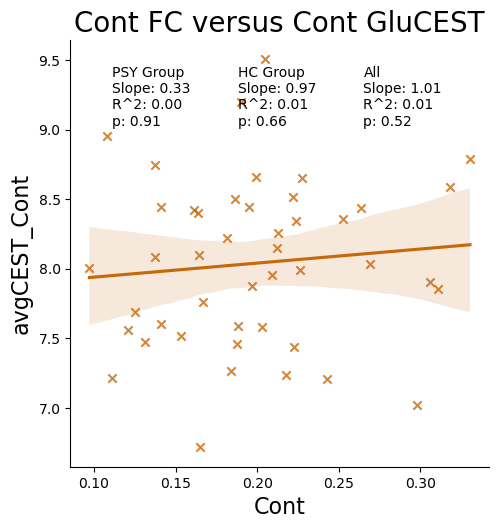

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


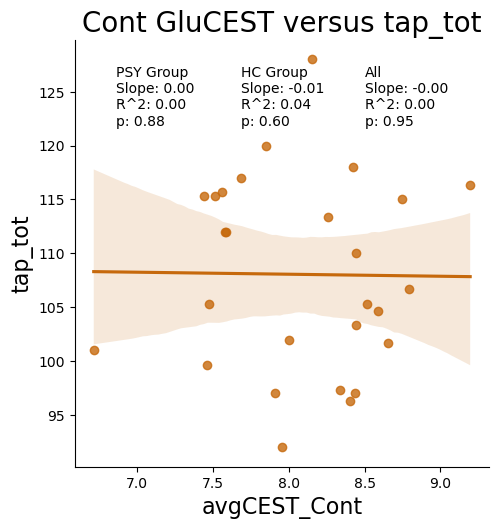

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


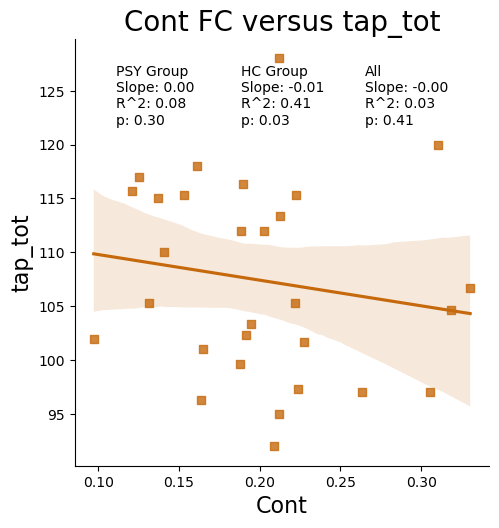

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


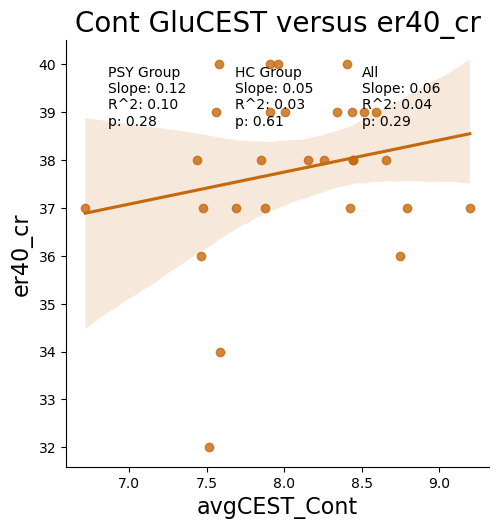

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


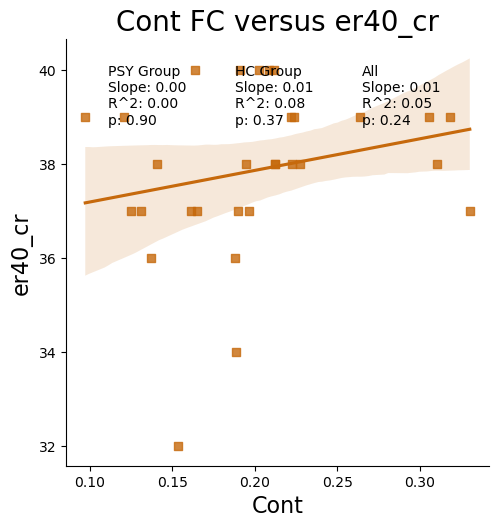

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


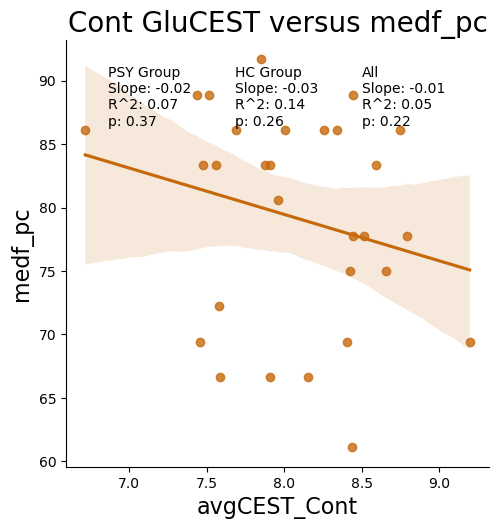

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


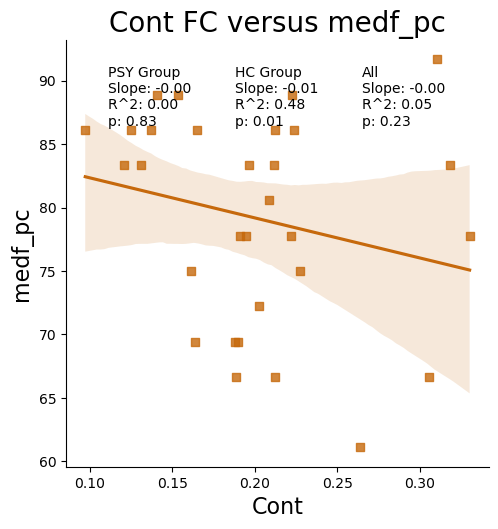

  dx_pscat_  avgCEST_Cont_mean  avgCEST_Cont_std  Cont_mean  Cont_std
0        HC           8.017359          0.572808   0.193100  0.069504
1     Other           8.158703          0.501141   0.219715  0.063397
2       PSY           7.992403          0.616050   0.193145  0.046284


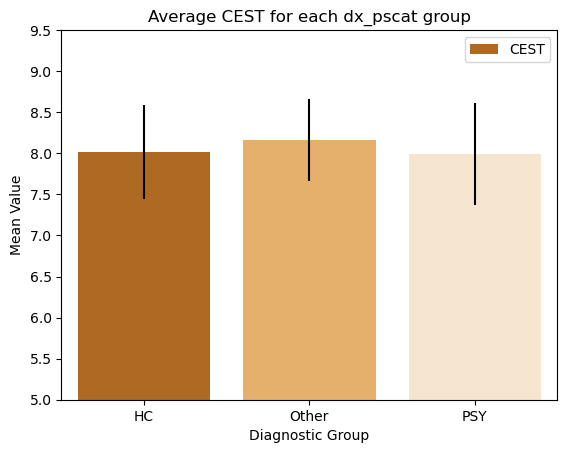

CEST t test: t=nan, p=nan


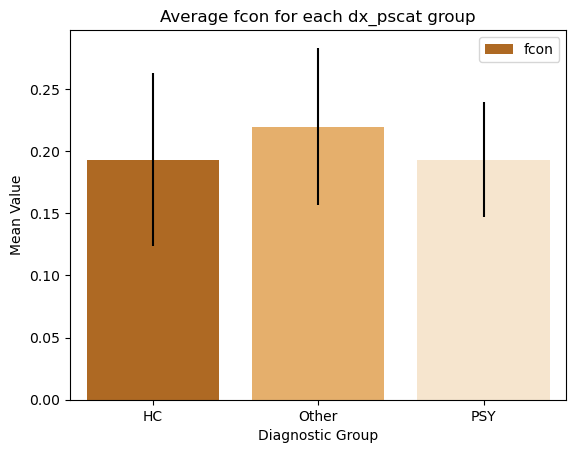

FC t test: t=nan, p=nan


/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


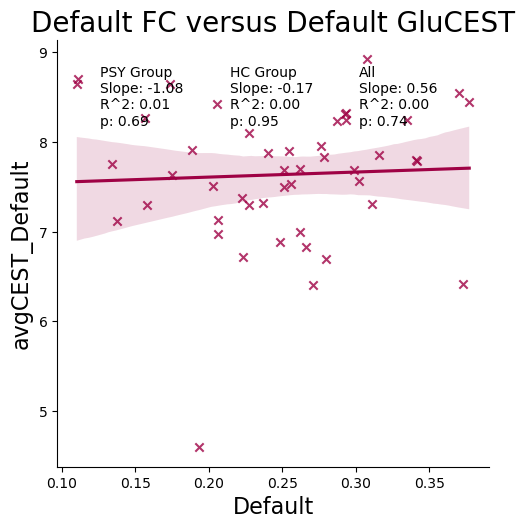

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


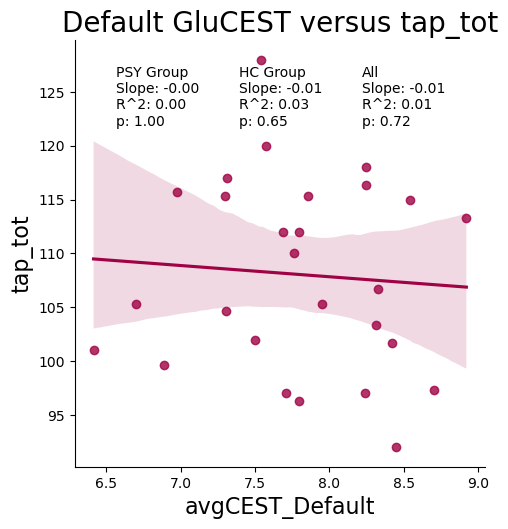

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


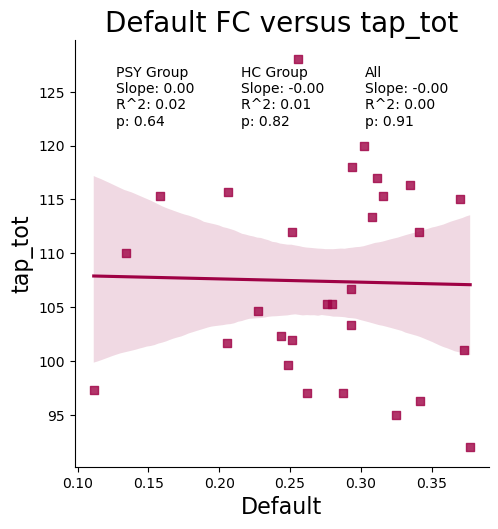

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


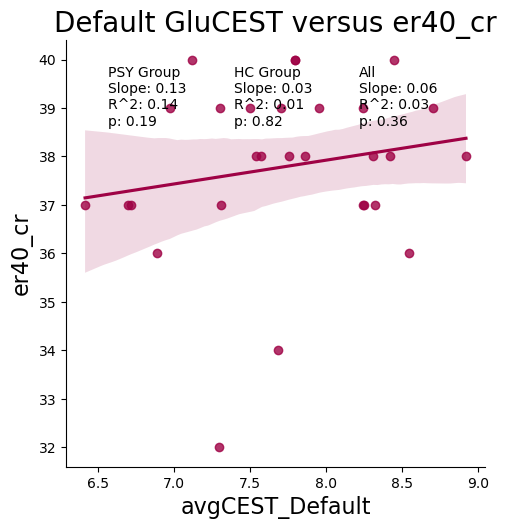

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


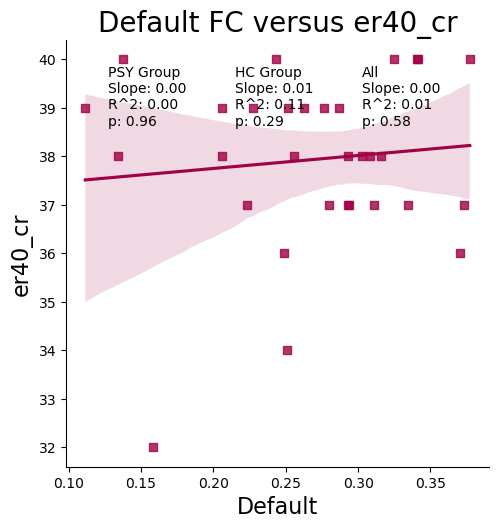

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


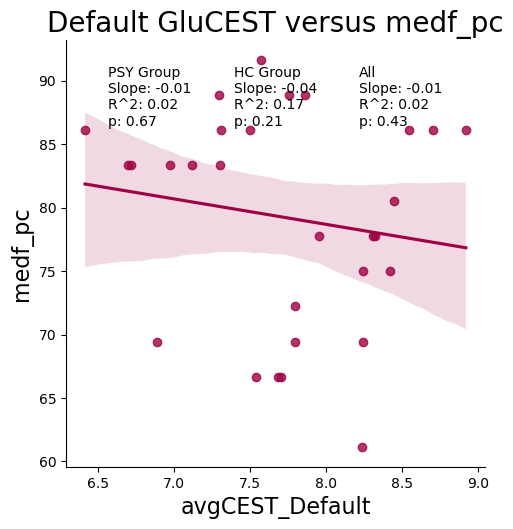

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


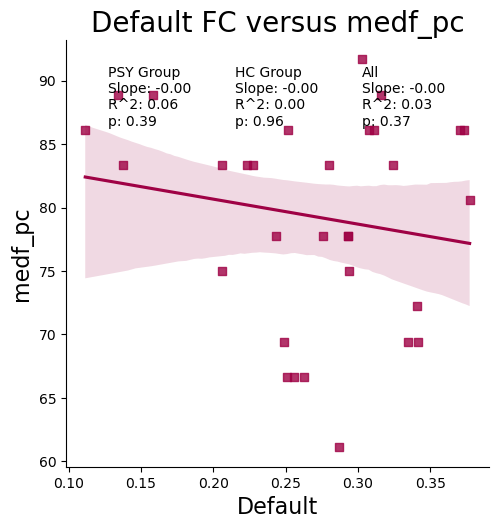

  dx_pscat_  avgCEST_Default_mean  avgCEST_Default_std  Default_mean  \
0        HC              7.619260             0.685101      0.242413   
1     Other              7.633963             0.756869      0.256021   
2       PSY              7.580762             0.784967      0.256972   

   Default_std  
0     0.067056  
1     0.082010  
2     0.062993  


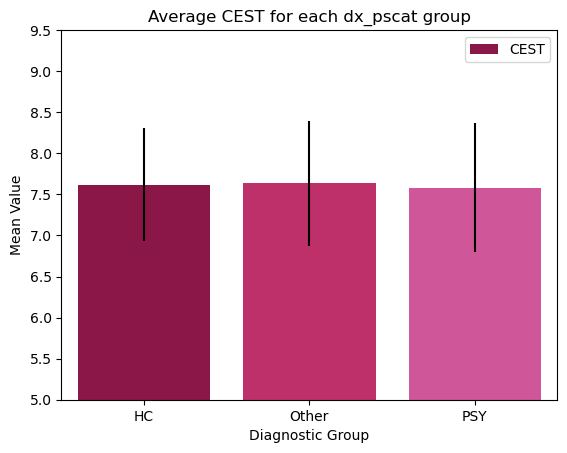

CEST t test: t=nan, p=nan


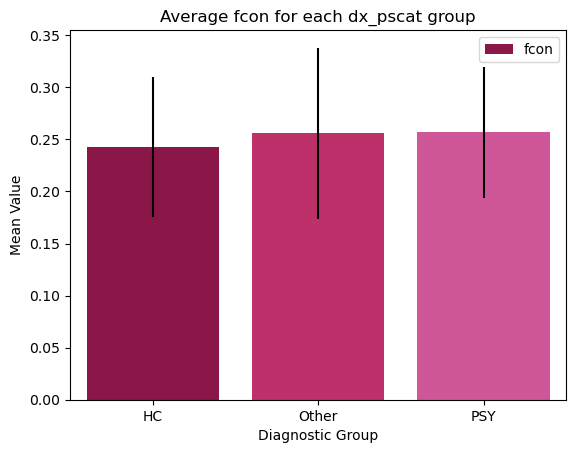

FC t test: t=nan, p=nan


/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


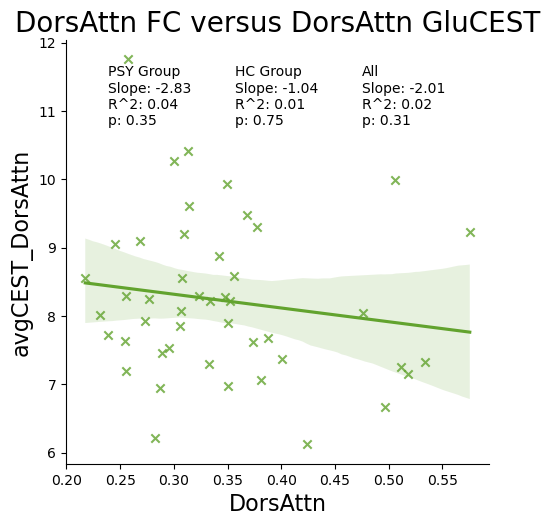

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


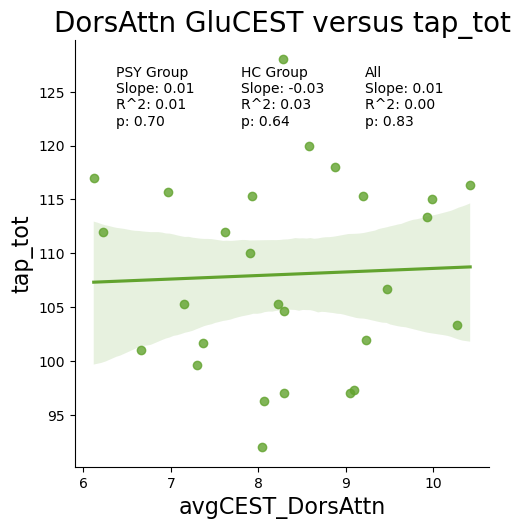

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


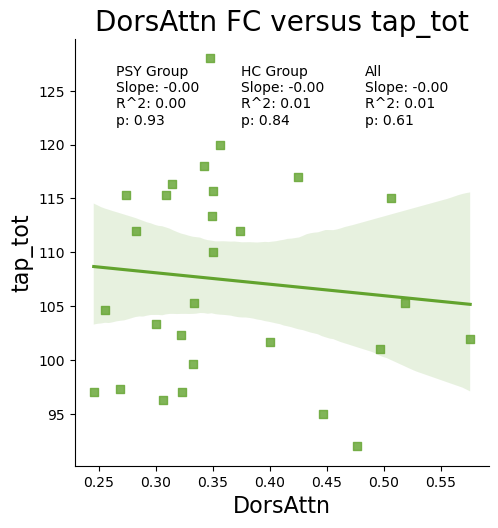

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


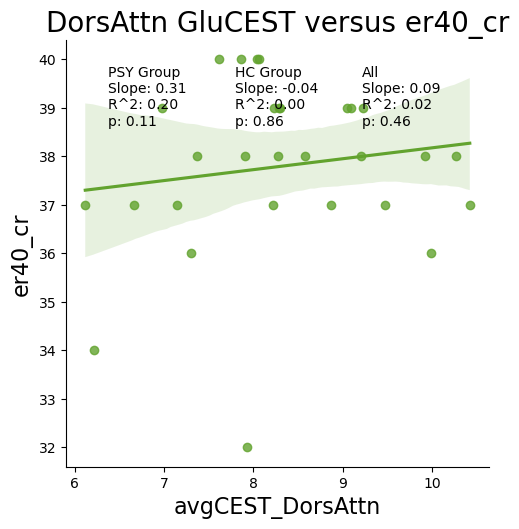

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


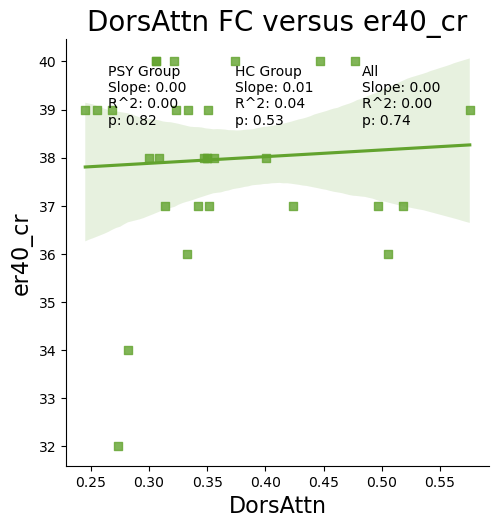

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


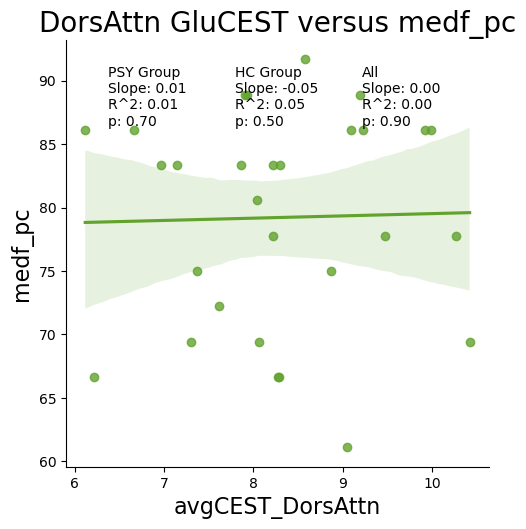

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


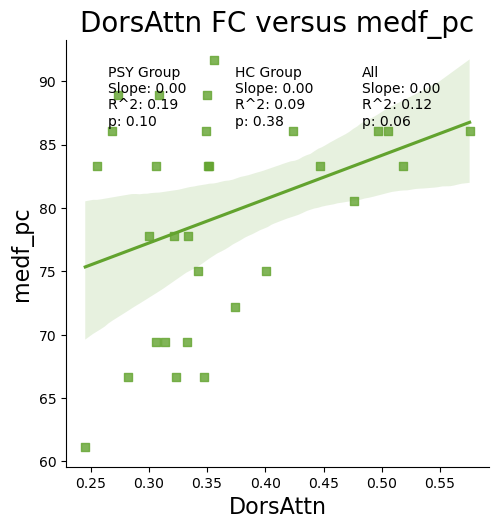

  dx_pscat_  avgCEST_DorsAttn_mean  avgCEST_DorsAttn_std  DorsAttn_mean  \
0        HC               8.113717              1.137114       0.359604   
1     Other               8.475148              0.763232       0.358138   
2       PSY               8.205319              1.210931       0.332613   

   DorsAttn_std  
0      0.094857  
1      0.075501  
2      0.083727  


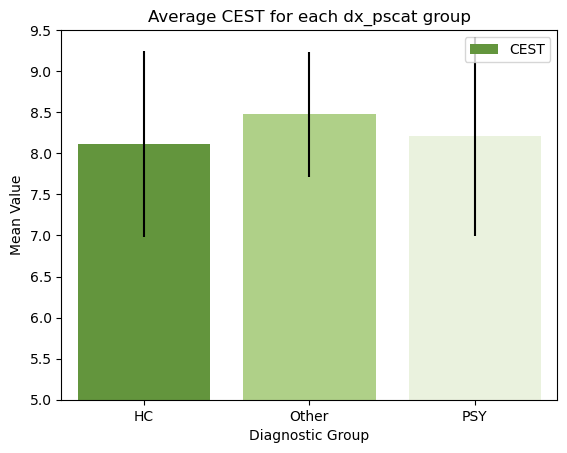

CEST t test: t=nan, p=nan


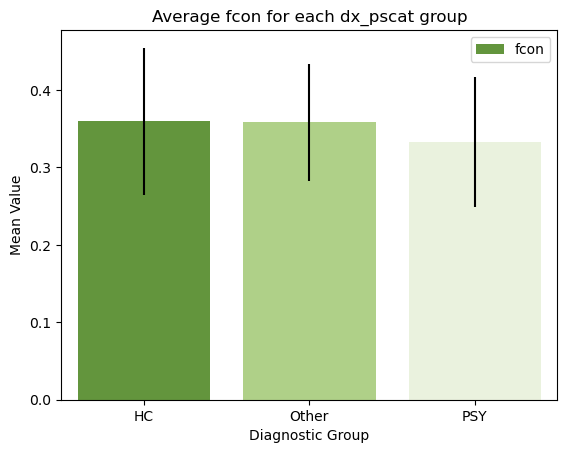

FC t test: t=nan, p=nan


/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


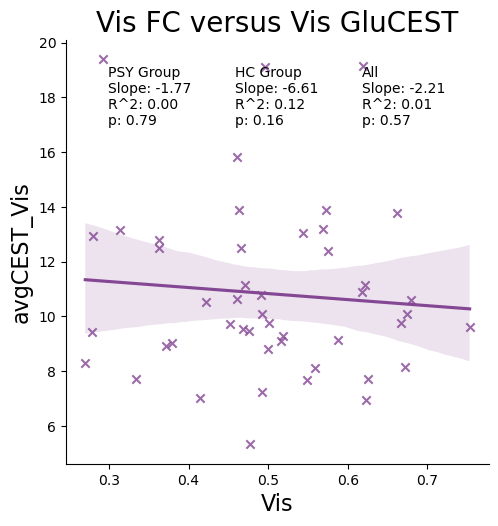

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


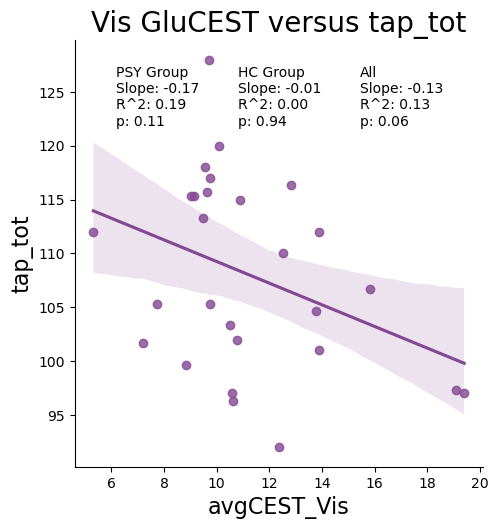

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


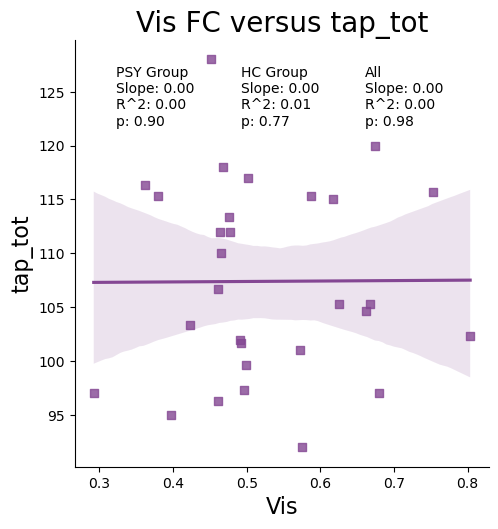

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


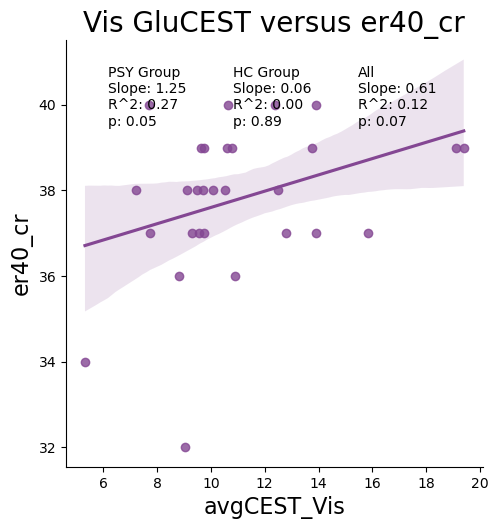

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


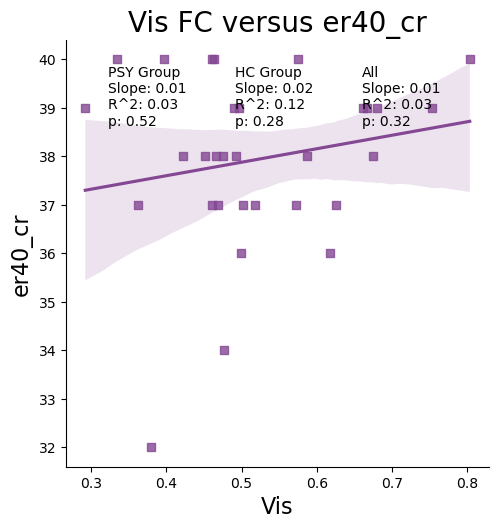

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


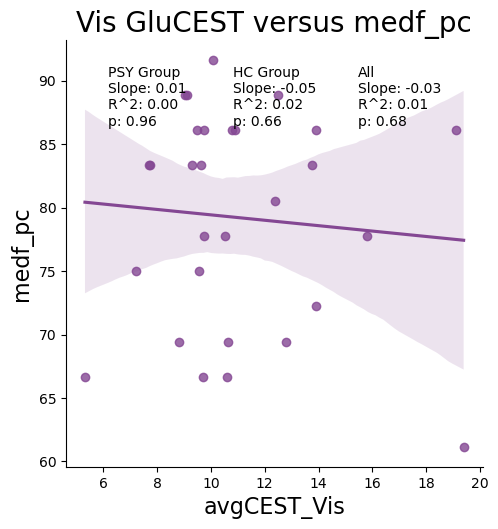

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


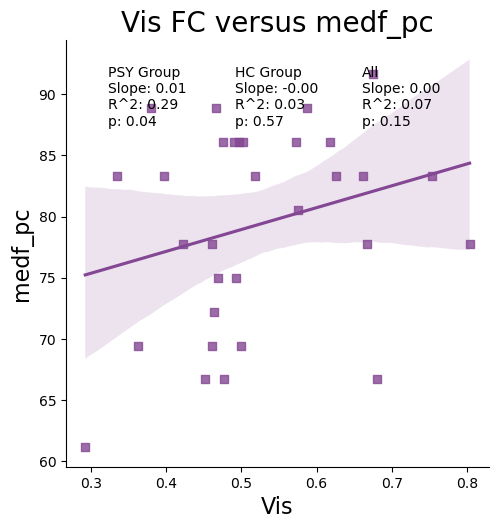

  dx_pscat_  avgCEST_Vis_mean  avgCEST_Vis_std  Vis_mean   Vis_std
0        HC         10.056458         2.212548  0.504887  0.118689
1     Other         12.495808         3.046988  0.476942  0.124653
2       PSY         10.983142         3.604429  0.504504  0.131761


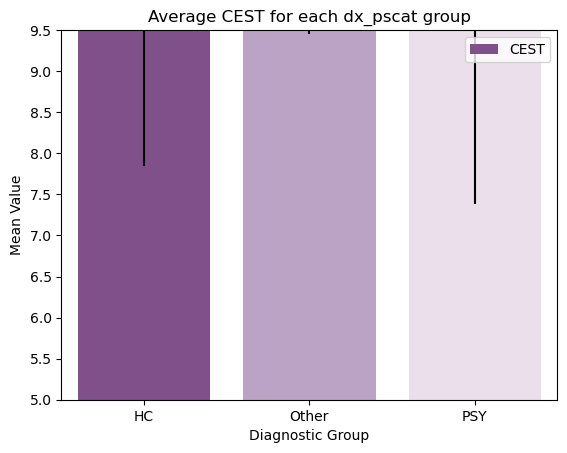

CEST t test: t=nan, p=nan


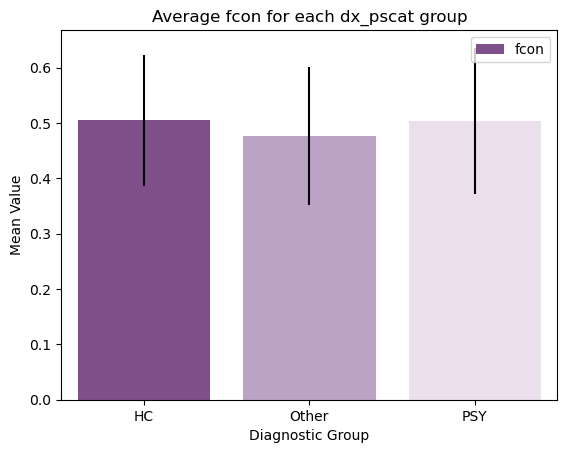

FC t test: t=nan, p=nan


/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


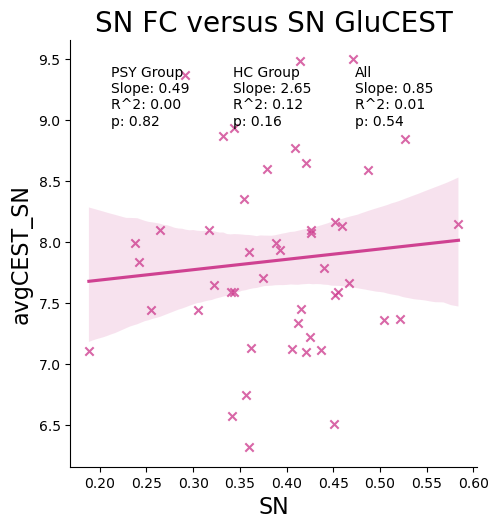

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


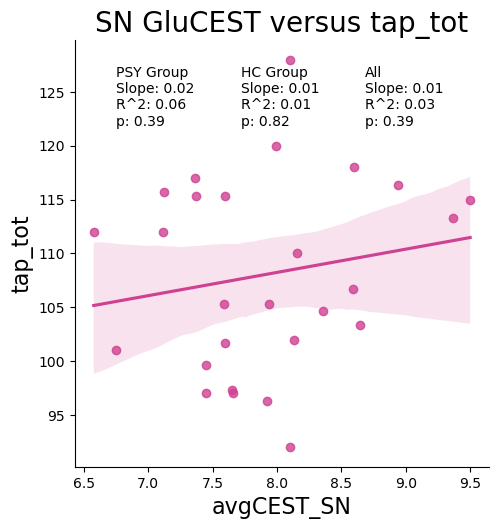

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


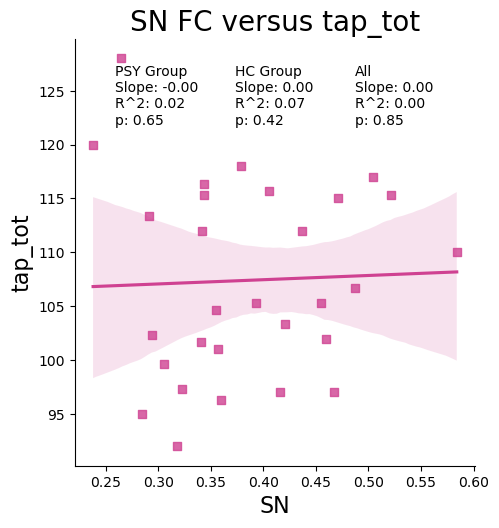

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


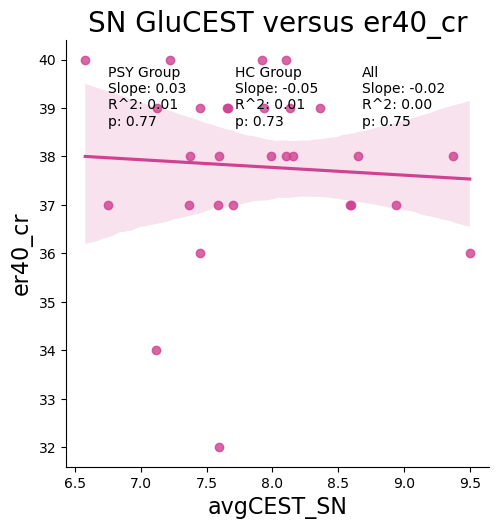

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


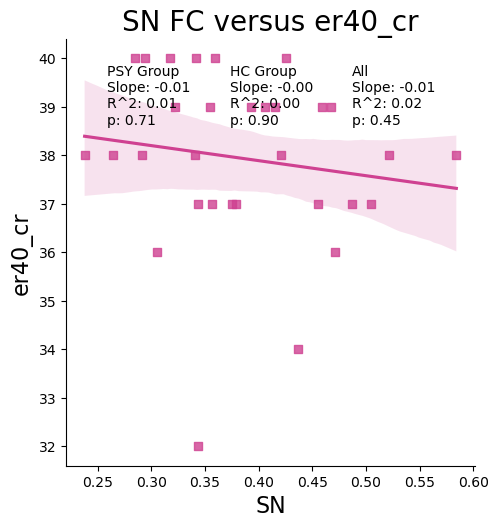

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


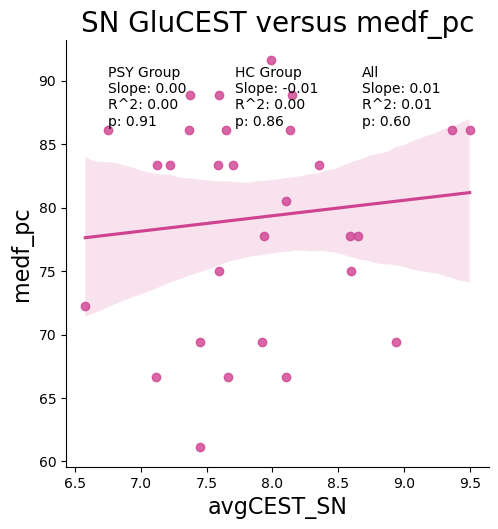

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


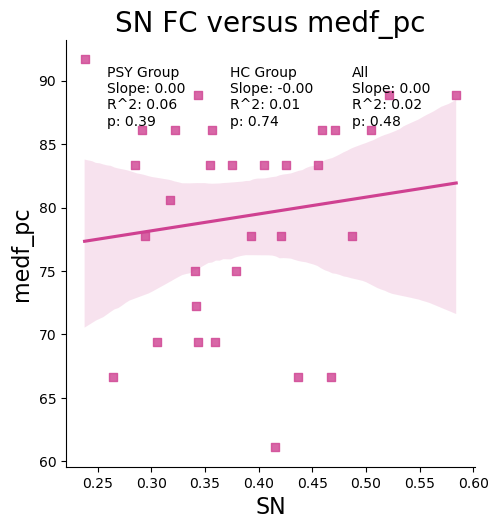

  dx_pscat_  avgCEST_SalVentAttn_mean  avgCEST_SalVentAttn_std  \
0        HC                  7.865913                 0.705147   
1     Other                  8.248664                 0.833359   
2       PSY                  7.704899                 0.754240   

   SalVentAttn_mean  SalVentAttn_std  
0          0.384816         0.094407  
1          0.344216         0.047673  
2          0.394105         0.076620  


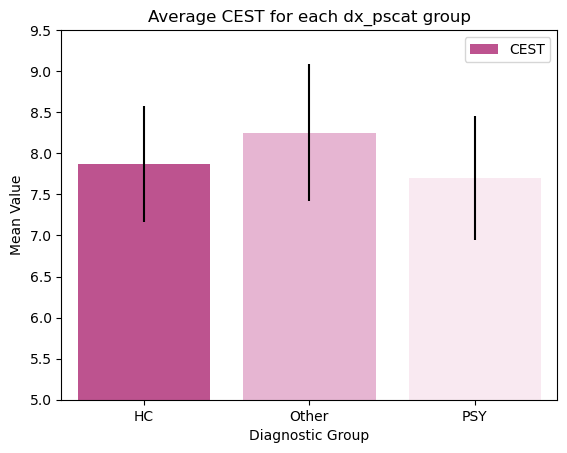

CEST t test: t=nan, p=nan


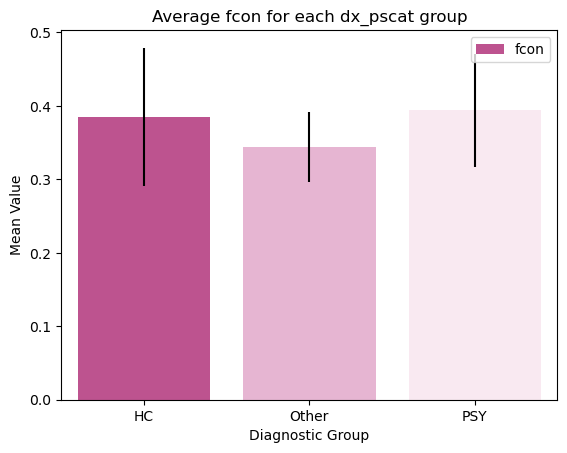

FC t test: t=nan, p=nan


/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


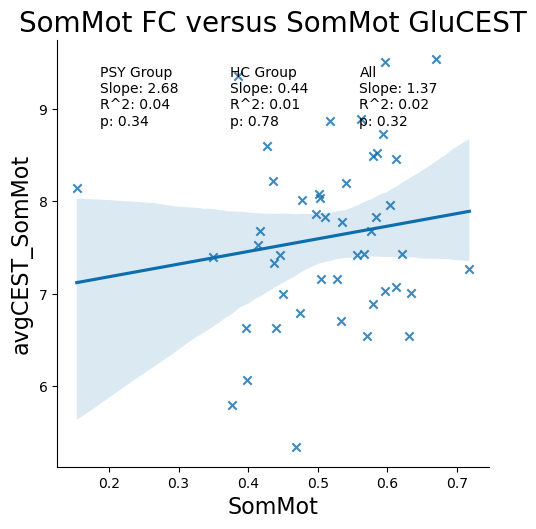

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


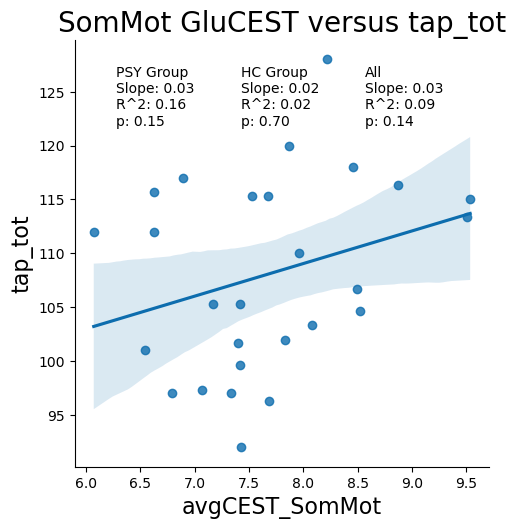

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


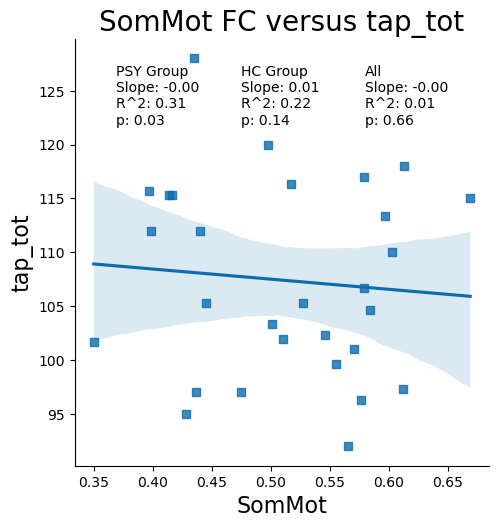

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


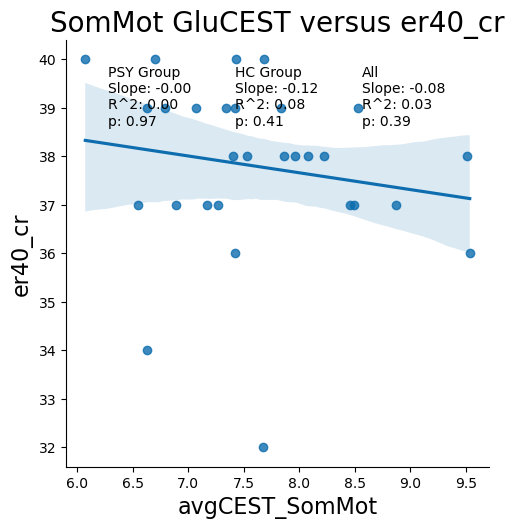

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


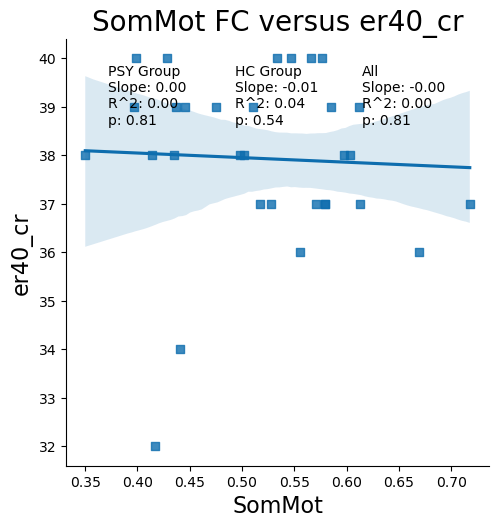

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


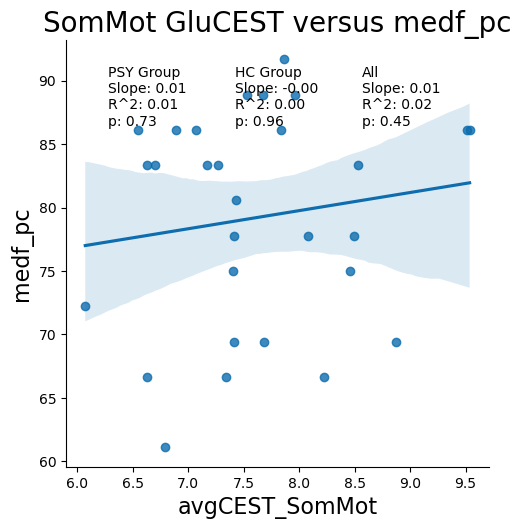

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


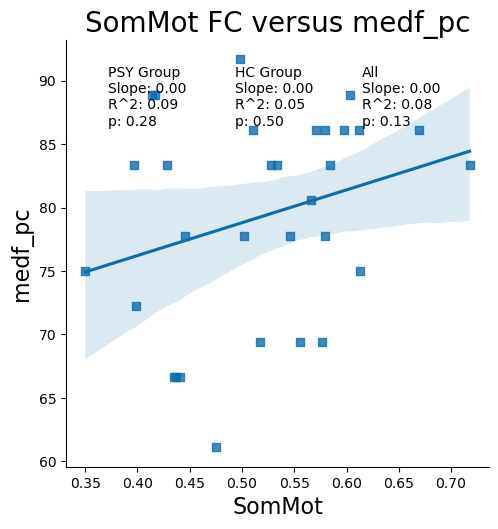

  dx_pscat_  avgCEST_SomMot_mean  avgCEST_SomMot_std  SomMot_mean  SomMot_std
0        HC             7.611026            0.812215     0.505814    0.133874
1     Other             8.136669            1.072822     0.563127    0.038936
2       PSY             7.457528            0.951744     0.504059    0.071643


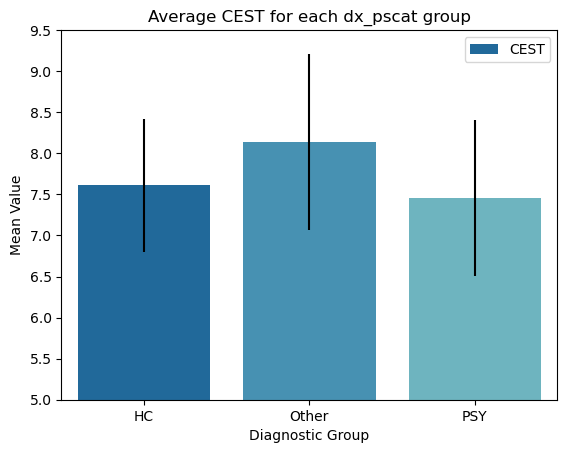

CEST t test: t=nan, p=nan


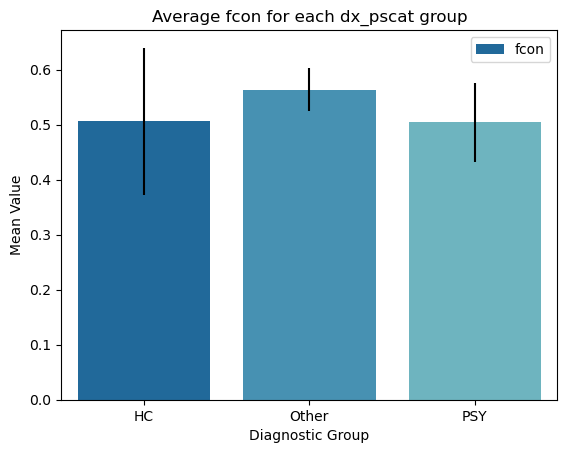

FC t test: t=nan, p=nan


/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


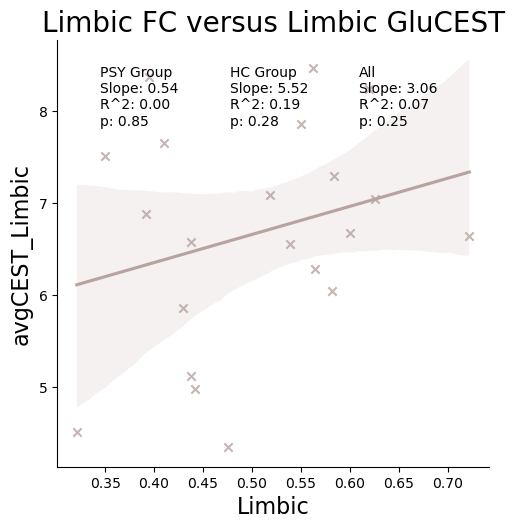

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


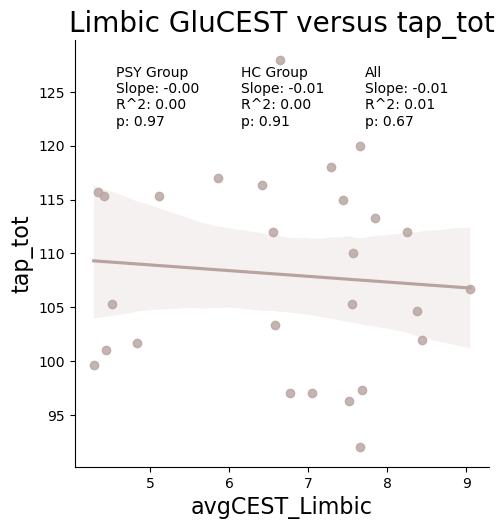

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


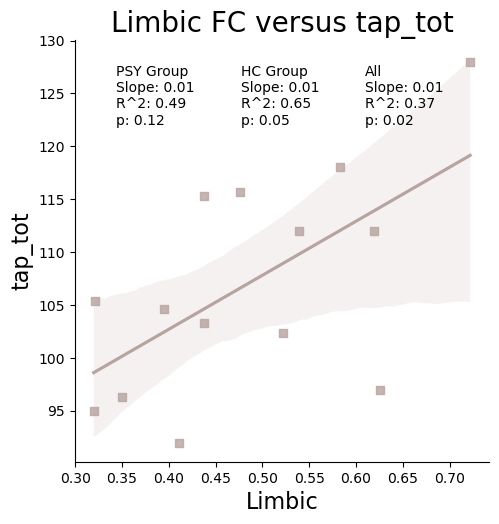

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


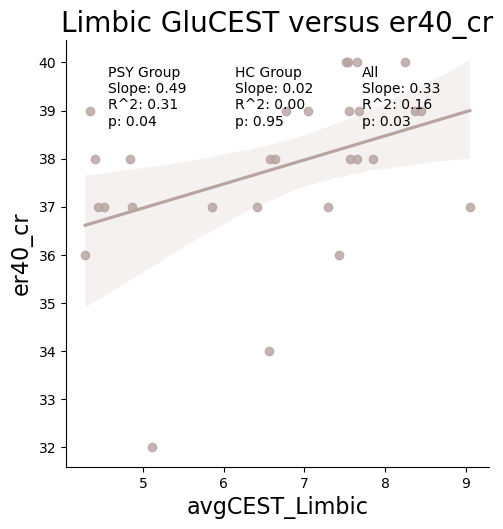

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


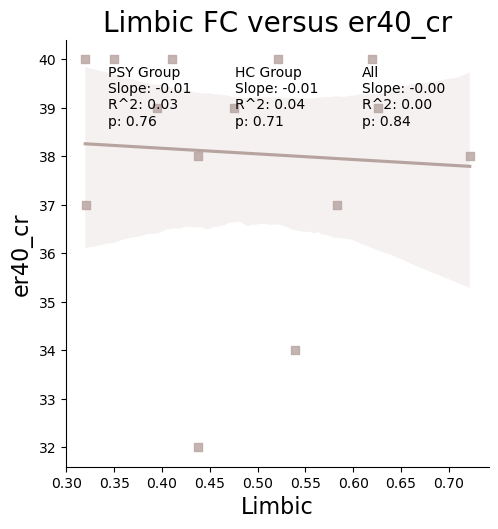

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


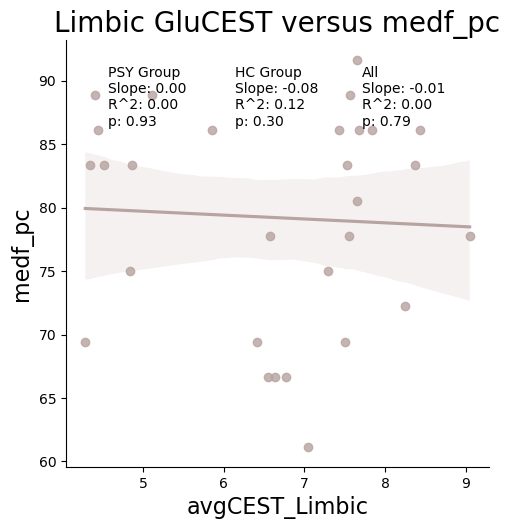

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


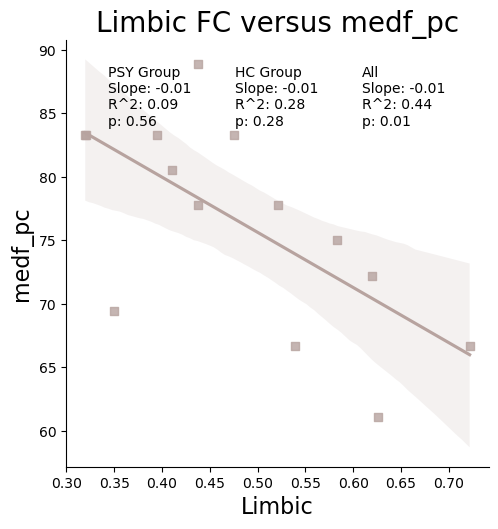

  dx_pscat_  avgCEST_Limbic_mean  avgCEST_Limbic_std  Limbic_mean  Limbic_std
0        HC             6.472853            1.467783     0.443256    0.095440
1     Other             7.328061            0.727692     0.439626    0.064619
2       PSY             7.035363            1.206819     0.550201    0.095074


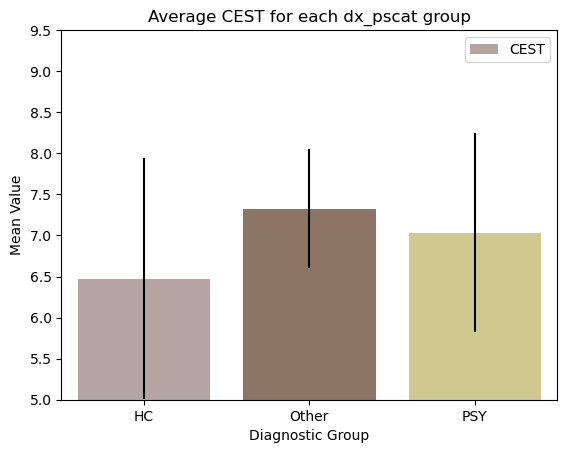

CEST t test: t=nan, p=nan


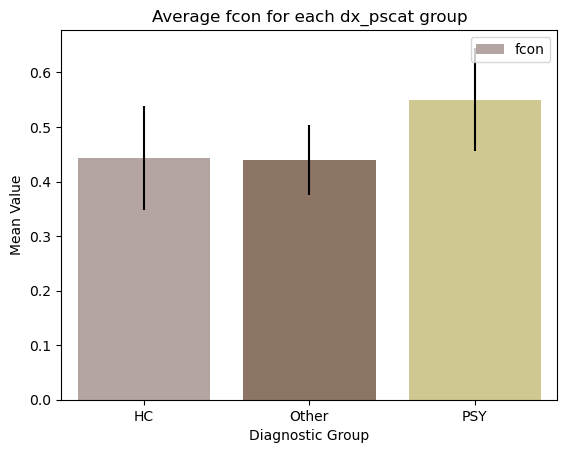

FC t test: t=nan, p=nan


In [7]:
# Create a scatter plot with a linear regression line
for network in networks:
    cestcol = "avgCEST_" + network
    #graph_df = grp_df[grp_df['dx_pscat'] != 'Other']
    graph_df = grp_df
    graph_df = graph_df.dropna(subset=[network, cestcol, 'dx_pscat'])
    # Create a linear regression model for fcon
    color = colors.loc[colors['Network'] == network, 'Color'].values[0]
    sns.set_palette(color)
    plot = sns.lmplot(x=network, y=cestcol, data=graph_df, markers= "x") #hue='dx_pscat', 
    if network == "SalVentAttn":
        plt.xlabel("SN", fontsize=16)
        plt.ylabel("avgCEST_SN", fontsize=16)
        plt.title('SN FC versus SN GluCEST', fontsize = 20)
    else:
        plt.xlabel(network, fontsize=16)
        plt.ylabel(cestcol, fontsize=16)
        plt.title(network + ' FC versus ' + network + ' GluCEST' , fontsize = 20)
    # Generate and add slope, r2 and p for subset 1
    slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'PSY', network], graph_df.loc[graph_df['dx_pscat'] == 'PSY', cestcol])
    plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
#     # Generate and add slope, r2 and p for subset 2
    slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'HC', network], graph_df.loc[graph_df['dx_pscat'] == 'HC', cestcol])
    plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    # Generate and add slope, r2 and p for all data
    slope, intercept, r_value, p_value, std_err = linregress(graph_df[network], graph_df[cestcol])
    plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    plt.show() 

    # Create CNB correlation plot for each network fcon and cest 
    for CNB_score in CNB_scores:
     #   graph_df = grp_df[grp_df['dx_pscat'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, cestcol, 'dx_pscat'])
        # Add labels and a title to the plot
        plot = sns.lmplot(x=cestcol, y=CNB_score,data=graph_df) # hue='dx_pscat',
        if network == "SalVentAttn":
            plt.xlabel("avgCEST_SN", fontsize=16)
            plt.title('SN GluCEST versus ' + CNB_score, fontsize = 20)
        else: 
            plt.xlabel(cestcol, fontsize=16)
            plt.title(network + ' GluCEST versus ' + CNB_score, fontsize = 20)
        plt.ylabel(CNB_score, fontsize=16)
        # Generate and add slope, r2 and p for subset 1
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'PSY', CNB_score], graph_df.loc[graph_df['dx_pscat'] == 'PSY', cestcol])
        plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for subset 2
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'HC', CNB_score], graph_df.loc[graph_df['dx_pscat'] == 'HC', cestcol])
        plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for all data
        slope, intercept, r_value, p_value, std_err = linregress(graph_df[CNB_score], graph_df[cestcol])
        plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)   
        # Show the plot
        plt.show()    

        #graph_df = grp_df[grp_df['dx_pscat'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, network, 'dx_pscat'])
        # Add labels and a title to the plot
        plot = sns.lmplot(x=network, y=CNB_score, data=graph_df, markers= "s") #hue='dx_pscat',
        if network == "SalVentAttn":
            plt.xlabel("SN", fontsize=16)
            plt.title('SN FC versus ' + CNB_score, fontsize = 20)
        else:
            plt.xlabel(network, fontsize=16)
            plt.title(network + ' FC versus ' + CNB_score, fontsize = 20)
        plt.ylabel(CNB_score, fontsize=16)
        # Generate and add slope, r2 and p for subset 1
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'PSY', CNB_score], graph_df.loc[graph_df['dx_pscat'] == 'PSY', network])
        plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for subset 2
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'HC', CNB_score], graph_df.loc[graph_df['dx_pscat'] == 'HC', network])
        plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for all data
        slope, intercept, r_value, p_value, std_err = linregress(graph_df[CNB_score], graph_df[network])
        plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)   
        # Show the plot
        plt.show()  

    # Make bar graph comparing diagnostic groups
    avg_df = grp_df.groupby('dx_pscat').agg({cestcol: ['mean', 'std'], network: ['mean', 'std']}).reset_index()
    # Flatten the multi-level columns
    avg_df.columns = ['_'.join(col).strip() for col in avg_df.columns.values]
    print(avg_df)

    
    # Plot CEST bar graph with error bars
    sns.barplot(x='dx_pscat_', y=cestcol + '_mean', data=avg_df, yerr=avg_df[cestcol + '_std'], label='CEST')
    plt.xlabel('Diagnostic Group')
    plt.ylabel('Mean Value')
    plt.ylim(5, 9.5)
    plt.title('Average CEST for each dx_pscat group')
    plt.legend()
    plt.show()
    t_statistic, p_value = ttest_ind(grp_df.loc[grp_df['dx_pscat'] == 'PSY', 'avgCEST_SomMot'],
                                     grp_df.loc[grp_df['dx_pscat'] == 'HC', 'avgCEST_SomMot'])
    print('CEST t test: t=' + str(t_statistic) + ', p=' + str(p_value))
    # Plot fcon bar graph with error bars
    sns.barplot(x='dx_pscat_', y=network + '_mean', data=avg_df, yerr=avg_df[network + '_std'], label='fcon')
    plt.xlabel('Diagnostic Group')
    plt.ylabel('Mean Value')
    plt.title('Average fcon for each dx_pscat group')
    plt.legend()
    plt.show()
    t_statistic, p_value = ttest_ind(grp_df.loc[grp_df['dx_pscat'] == 'PSY', 'SomMot'],
                                     grp_df.loc[grp_df['dx_pscat'] == 'HC', 'SomMot'])
    print('FC t test: t=' + str(t_statistic) + ', p=' + str(p_value))


### Multiple Linear Regressions

['Unnamed: 0', 'BBLID', 'Session', 'sex', 'age', 'race', 'ethnic', 'dateDiff', 'SomMot', 'avgCEST_SomMot', 'ctCEST_SomMot', 'tap_tot', 'hstatus']
is panda
CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:         avgCEST_SomMot   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     2.845
Date:                Fri, 02 Feb 2024   Prob (F-statistic):             0.0721
Time:                        15:05:19   Log-Likelihood:                -46.244
No. Observations:                  37   AIC:                             98.49
Df Residuals:                      34   BIC:                             103.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std

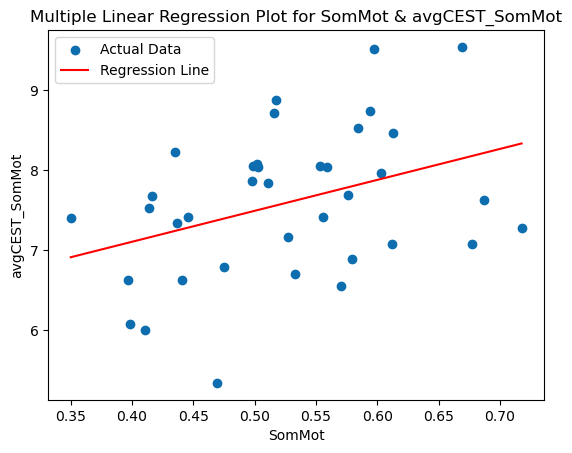

In [37]:
graph_df = grp_df
print(graph_df.columns.tolist())
print("is panda") if type(graph_df) == pd.core.frame.DataFrame else print("not panda")

for network in networks:
    formula = f'{cestcol} ~ {network} + {covariate_age}'
    model = smf.ols(formula=formula, data=graph_df).fit()
    print('CEST-FC Association in all') 
    print(model.summary())

    fig, ax = plt.subplots()
    ax.scatter(graph_df[network], graph_df[cestcol], label='Actual Data')
    # Generate x values for the line
    x_line = pd.DataFrame({network: np.linspace(graph_df[network].min(), graph_df[network].max(), 100),
                           covariate_age: np.mean(graph_df[covariate_age])})  # Use mean value for the network variable
    # Predictions for the regression line
    y_line = model.predict(x_line)
    # Plot the regression line
    ax.plot(x_line[network], y_line, color='red', label='Regression Line')
    ax.set_xlabel(network)
    ax.set_ylabel(cestcol)
    ax.set_title('Multiple Linear Regression Plot for ' + network + ' & ' + cestcol)
    ax.legend()
    plt.show()
    


Regression of avgCEST_SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.131
Date:                Tue, 06 Feb 2024   Prob (F-statistic):              0.351
Time:                        12:14:54   Log-Likelihood:                -60.918
No. Observations:                  17   AIC:                             127.8
Df Residuals:                      14   BIC:                             130.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


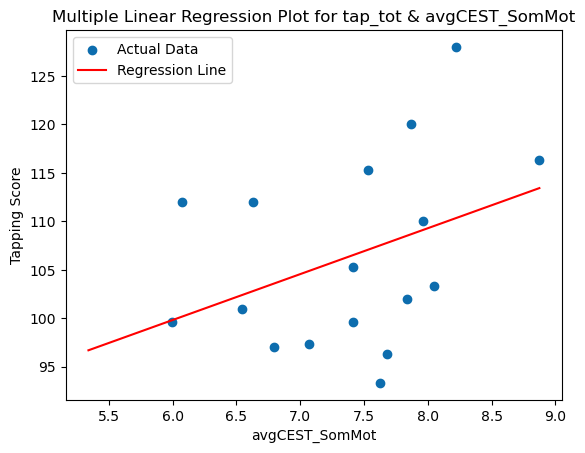

Regression of SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     2.819
Date:                Tue, 06 Feb 2024   Prob (F-statistic):             0.0936
Time:                        12:14:55   Log-Likelihood:                -59.314
No. Observations:                  17   AIC:                             124.6
Df Residuals:                      14   BIC:                             127.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


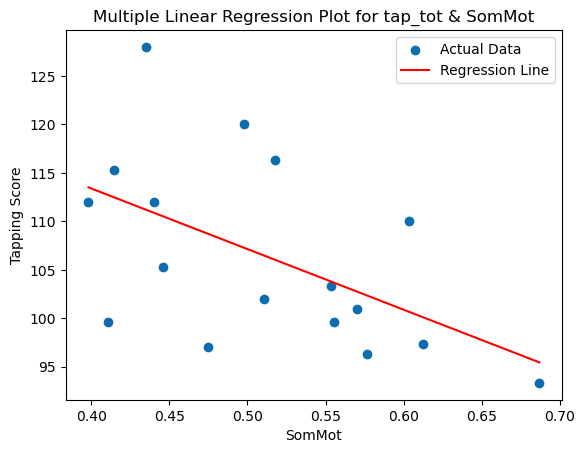

In [188]:
# First, replicate main findings of CEST and FC vs taptot using multiple linear regression to control for age and sex.p
for CNB_score in CNB_scores:
    for metric in metrics: 
        formula = f'{CNB_score} ~ {metric} + {covariate_age}' #FIX add covariate_sex
        model = smf.ols(formula=formula, data=graph_df).fit()
        print('Regression of ' + metric + ' vs taptot in all') 
        print(model.summary())

        fig, ax = plt.subplots()
        ax.scatter(graph_df[metric], graph_df['tap_tot'], label='Actual Data')
        # Generate x values for the line
        x_line = pd.DataFrame({metric: np.linspace(graph_df[metric].min(), graph_df[metric].max(), 100),
                               covariate_age: np.mean(graph_df[covariate_age])}) #FIX: add covariate_sex: graph_df[covariate_age] 
        # Predictions for the regression line
        y_line = model.predict(x_line)
        # Plot the regression line
        ax.plot(x_line[metric], y_line, color='red', label='Regression Line')
        ax.set_xlabel(metric)
        ax.set_ylabel('Tapping Score')
        ax.set_title('Multiple Linear Regression Plot for ' + CNB_score + ' & ' + metric)
        ax.legend()
        plt.show()





Regression of avgCEST_SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                 -0.124
Method:                 Least Squares   F-statistic:                    0.2832
Date:                Tue, 06 Feb 2024   Prob (F-statistic):              0.759
Time:                        12:15:52   Log-Likelihood:                -48.289
No. Observations:                  14   AIC:                             102.6
Df Residuals:                      11   BIC:                             104.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


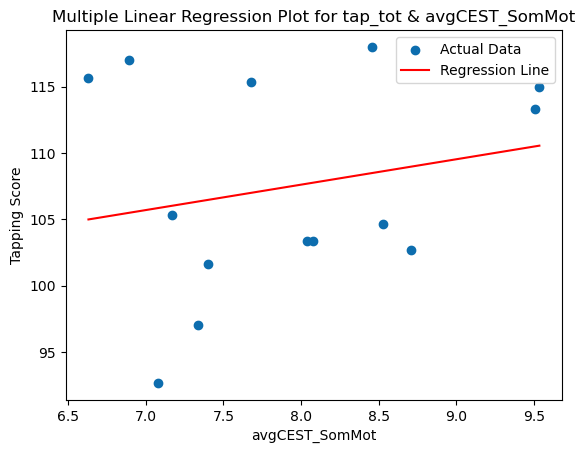

Regression of SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.176
Method:                 Least Squares   F-statistic:                   0.02490
Date:                Tue, 06 Feb 2024   Prob (F-statistic):              0.975
Time:                        12:15:52   Log-Likelihood:                -48.609
No. Observations:                  14   AIC:                             103.2
Df Residuals:                      11   BIC:                             105.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


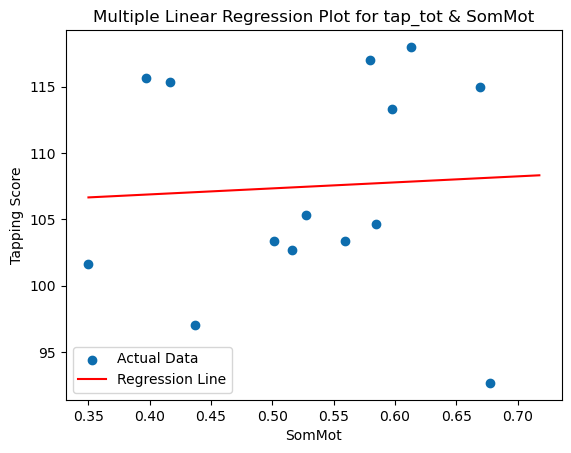

Regression of avgCEST_SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.131
Date:                Tue, 06 Feb 2024   Prob (F-statistic):              0.351
Time:                        12:15:53   Log-Likelihood:                -60.918
No. Observations:                  17   AIC:                             127.8
Df Residuals:                      14   BIC:                             130.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


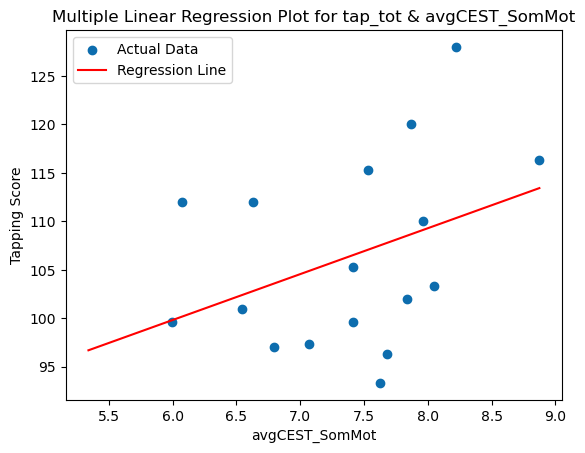

Regression of SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     2.819
Date:                Tue, 06 Feb 2024   Prob (F-statistic):             0.0936
Time:                        12:15:53   Log-Likelihood:                -59.314
No. Observations:                  17   AIC:                             124.6
Df Residuals:                      14   BIC:                             127.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


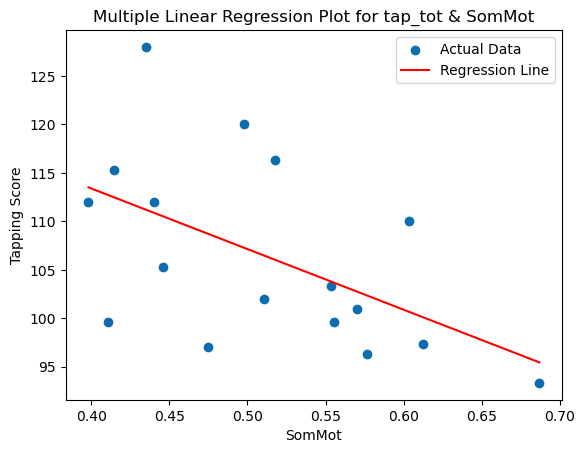

In [190]:
# Regression by dx_pscat of CEST and FC versus Tapping Score.
statuses = ['HC', 'PSY']
# Create a figure outside the loop to have a single plot
#fig, ax = plt.subplots()

for status in statuses:
    for metric in metrics:
        for CNB_score in CNB_scores:
            ##################################
            graph_df = grp_df[grp_df['dx_pscat'] == status]
            # Define formula and model
            formula = f'{CNB_score} ~ {metric} + {covariate_age}' #FIX add covariate_sex
            model = smf.ols(formula=formula, data=graph_df).fit()
            print('Regression of ' + metric + ' vs taptot in all') 
            print(model.summary())

            fig, ax = plt.subplots()
            ax.scatter(graph_df[metric], graph_df['tap_tot'], label='Actual Data')
            # Generate x values for the line
            x_line = pd.DataFrame({metric: np.linspace(graph_df[metric].min(), graph_df[metric].max(), 100),
                                   covariate_age: np.mean(graph_df[covariate_age])}) #FIX: add covariate_sex: graph_df[covariate_age] 
            # Predictions for the regression line
            y_line = model.predict(x_line)
            # Plot the regression line
            ax.plot(x_line[metric], y_line, color='red', label='Regression Line')
            ax.set_xlabel(metric)
            ax.set_ylabel('Tapping Score')
            ax.set_title('Multiple Linear Regression Plot for ' + CNB_score + ' & ' + metric)
            ax.legend()
            plt.show()





SomMot & tap_tot
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     5.004
Date:                Fri, 02 Feb 2024   Prob (F-statistic):             0.0139
Time:                        15:00:47   Log-Likelihood:                -106.41
No. Observations:                  31   AIC:                             218.8
Df Residuals:                      28   BIC:                             223.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         92.654

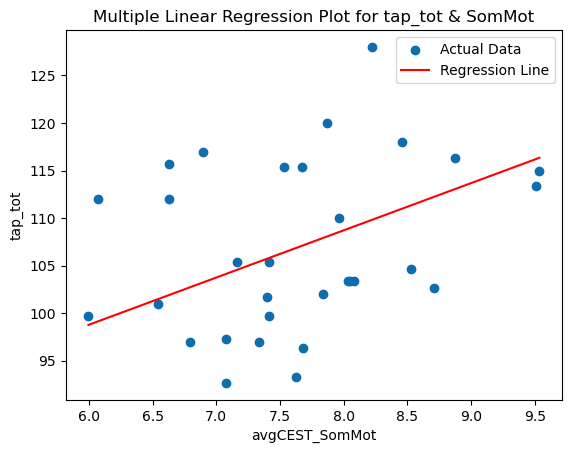

In [34]:
colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
    'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 

# Multiple linear regression predicting TapTot using SomMot and FC
for network in networks:
    cestcol = "avgCEST_" + network
    # Create a linear regression model for fcon

    # Create CNB correlation plot for each network fcon and cest 
    for CNB_score in CNB_scores:
     #   graph_df = grp_df[grp_df['dx_pscat'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, cestcol, network])
        graph_df = graph_df[[CNB_score, cestcol, network]]
        # Define x values and target variable
        X = graph_df[[cestcol, network]]
        Y = graph_df[CNB_score]

        ##################################
        # Define formula and model
        formula = f'{CNB_score} ~ {cestcol} + {network}'
        model = smf.ols(formula=formula, data=graph_df).fit()
        print('\n\n\n' + network + ' & ' + CNB_score) 
        print(model.summary())

        # Plotting the regression line
        fig, ax = plt.subplots()
        ax.scatter(graph_df[cestcol], graph_df[CNB_score], label='Actual Data')
        # Generate x values for the line
        x_line = pd.DataFrame({cestcol: np.linspace(graph_df[cestcol].min(), graph_df[cestcol].max(), 100),
                               network: np.mean(graph_df[network])})  # Use mean value for the network variable
        # Predictions for the regression line
        y_line = model.predict(x_line)
        # Plot the regression line
        ax.plot(x_line[cestcol], y_line, color='red', label='Regression Line')
        ax.set_xlabel(cestcol)
        ax.set_ylabel(CNB_score)
        ax.set_title('Multiple Linear Regression Plot for ' + CNB_score + ' & ' + network)
        ax.legend()
        plt.show()

### 3D Plot Troubleshooting

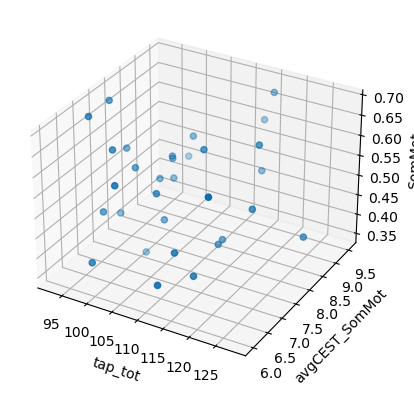

In [38]:
# BBS
colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
    'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 

# Create a scatter plot with a multiple linear regression 
for network in networks:
    cestcol = "avgCEST_" + network
    for CNB_score in CNB_scores:
     #   graph_df = grp_df[grp_df['dx_pscat'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, cestcol, network])
        graph_df = graph_df[[CNB_score, cestcol, network]]
        # Define x values and target variable
        X = graph_df[[cestcol, network]]
        Y = graph_df[CNB_score]

        ##################################
        fig = plt.figure()
        ax = fig.add_subplot(111, projection = '3d')
        ax.scatter(graph_df[CNB_score], graph_df[cestcol], graph_df[network])
        ax.set_xlabel(CNB_score)
        ax.set_ylabel(cestcol)
        ax.set_zlabel(network)
        plt.show()

In [ ]:
###Save Output

In [39]:
!jupyter nbconvert --to html motor_figures.ipynb --output motor_figures_3T.html

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook motor_figures.ipynb to html
[NbConvertApp] Writing 1101856 bytes to motor_figures_3T.html
